# 0. Imports

In [1]:
import os

# for data handling
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for data splitting
from sklearn.model_selection import train_test_split

# for data pre-processing
from sklearn.feature_extraction.text import TfidfVectorizer

# for saving train, valid, test data
from scipy.sparse import save_npz

from wordcloud import WordCloud
import re
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ankita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ankita\AppData\Roaming\nltk_data...


True

# 1. Loading the data

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'])
    # convert labels to binary int 0/1
    df['label'] = df['label'].map({'ham':0, 'spam':1})
    return df

In [3]:
data_path = os.path.join('data', 'SMSSpamCollection')
print(data_path)

data\SMSSpamCollection


In [4]:
data = load_data(data_path)

In [5]:
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [7]:
data.loc[data.label == 'spam', 'label'] = 1
data.loc[data.label == 'ham', 'label'] = 0

In [8]:
def visualize(label):
    words = ''
    for msg in data[data['label']==label]['text']:
        msg = msg.lower()
        words+=msg + ' '
    wordcloud = WordCloud(width=600,height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')

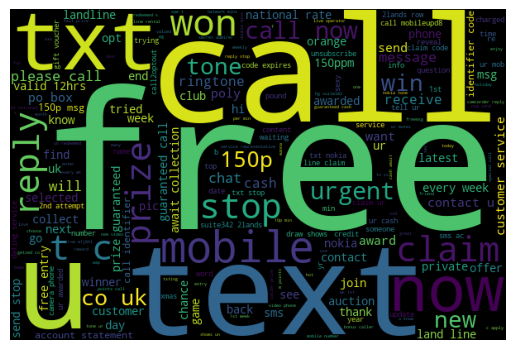

In [9]:
visualize(1)

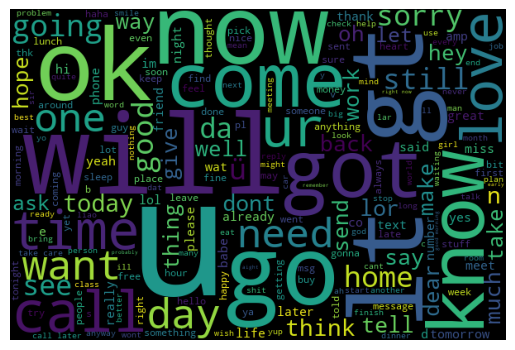

In [10]:
visualize(0)

In [15]:
word_tokens=[]
regex=r"\w+"
for i in range(len(data['text'])):
  word_tokens.append(re.findall(regex,data.text[i]))

In [18]:
filtered_word_tokens=[]
lemmatizer = WordNetLemmatizer()
for i in range(len(word_tokens)):

  temp=[]

  for j in range(len(word_tokens[i])):
        
    if word_tokens[i][j].lower() in stop_words:
      continue
      
    elif word_tokens[i][j] in string.punctuation:
      continue
            
    else:
      temp.append(lemmatizer.lemmatize(word_tokens[i][j].lower()))   

  filtered_word_tokens.append(temp)

In [19]:
data['Preprocessed']=filtered_word_tokens 

In [20]:
data.head()

,label,text,Preprocessed
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, life, around, though]"


In [21]:
def joinList(text):
    return " ".join(text)

data["Message"] = data["Preprocessed"].map(joinList)

In [22]:
data.head()

,label,text,Preprocessed,Message
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, life, around, though]",nah think go usf life around though


# 2. Pre-processing

In [25]:
def preprocess_data(df):
    # convert a collection of raw documents to a matrix of TF-IDF features
    
    # extract features and labels
    features = df['text'].copy()
    labels = df['label'].copy()

    # initialize the vectorizer
    TfVectorizer = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)

    # transform the features
    features = TfVectorizer.fit_transform(features)
    
    # convert from scipy sparse matrix to pandas dataframe
    features = pd.DataFrame.sparse.from_spmatrix(features)

    return features, labels

In [26]:
features, labels = preprocess_data(data)

print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)

Features Shape: (5572, 8444)
Labels Shape: (5572,)


# 3. Splitting Data

In [27]:
def train_val_test_split(features, labels, random_state=None):
    # splitting into train, val, test
    
    # split into test and non-test
    X_non_test, X_test, y_non_test, y_test = train_test_split(features, labels, test_size=0.15, random_state=random_state)

    # split into train and val
    X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [28]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(features, labels, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (3788, 8444)
Validation Data Shape: (948, 8444)
Test Data Shape: (836, 8444)


# 4. Saving Data

In [29]:
data_train_save_path = os.path.join('data','train.csv')
data_val_save_path = os.path.join('data','val.csv')
data_test_save_path = os.path.join('data','test.csv')

train_val_test_save_paths = [data_train_save_path, data_val_save_path, data_test_save_path]

train_val_test_save_paths

['data\\train.csv', 'data\\val.csv', 'data\\test.csv']

In [30]:
def save_train_val_test_data(features, labels, train_val_test_save_paths, random_state):
    # extract train, test, val
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(features, labels, random_state=random_state)
    
    # save train, val, test data as .csv files
    train_data = pd.concat([X_train, y_train], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    # save as .csv files to the savepaths
    train_data.to_csv(train_val_test_save_paths[0], index=False)
    val_data.to_csv(train_val_test_save_paths[1], index=False)
    test_data.to_csv(train_val_test_save_paths[2], index=False)

    print("Train, Val, Test data saved to:\n", train_val_test_save_paths)
    
    return None

In [31]:
save_train_val_test_data(features, labels, train_val_test_save_paths, random_state=42)

Train, Val, Test data saved to:
 ['data\\train.csv', 'data\\val.csv', 'data\\test.csv']
